In [2]:
from WindPy import w

w.start()  # 默认命令超时时间为120秒，如需设置超时时间可以加入waitTime参数，例如waitTime=60,即设置命令超时时间为60秒

print("WindPy是否已经登录成功:{}".format(w.isconnected()))  # 判断WindPy是否已经登录成功

Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2020 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.
WindPy是否已经登录成功:True


In [3]:
# load the data with DataFrame
eroc,df=w.wsd("USDCNY.EX", "close", "2010-01-01", "2020-12-28", usedf=True)

In [4]:
df.describe()

,CLOSE
count,2671.000000
mean,6.537910
std,0.300385
min,6.093000
25%,6.289200
50%,6.532000
75%,6.826000
max,7.131600


In [5]:
df.plot()

In [6]:
def myhist(df_input, bins=30):
    import matplotlib.pyplot as plt
    import matplotlib.style as style
    import scipy.stats as stats
    import numpy as np


    df_input = np.array(df_input)
    if df_input.ndim>1:
        if df_input.shape[0]>1:
            df_input=df_input[:,0]
        else:
            df_input=df_input[0,:]


    style.use("ggplot")
    plt.rcParams["figure.figsize"] = (6, 4)
    plt.figure(dpi=100)
    heightofbins, aa, bb = plt.hist(df_input, bins)
    mu = df_input.mean()
    std = df_input.std()
    lowb = df_input.min()
    upb = df_input.max()

    # can use stats.norm.fit to get the std, mu
    # nloc,nscale=stats.norm.fit(df_input)

    # fit the data with a t location-scale model with MLE
    ## r=loc + scale * T(dof)

    tdof, tloc, tscale = stats.t.fit(df_input)

    # Change the shape of PDF to match the hist
    ## both norm and t distribution pdf are multiplied by a same number

    ### norm distribution
    xx = stats.norm.pdf(np.linspace(lowb - std, upb + std, 1000), loc=mu, scale=std)
    xx = xx * np.max(heightofbins) / stats.t.pdf(mu, df=tdof, loc=tloc, scale=tscale)
    plt.plot(np.linspace(lowb - std, upb + std, 1000), xx)

    ### rescaled t distribution
    y = stats.t.pdf(
        np.linspace(lowb - std, upb + std, 1000), df=tdof, loc=tloc, scale=tscale
    )
    y = y * np.max(heightofbins) / stats.t.pdf(mu, df=tdof, loc=tloc, scale=tscale)
    plt.plot(np.linspace(lowb - std, upb + std, 1000), y)

    plt.legend(["Normal PDF", "Rescaled t Distribution", "Sample Distribution"])

    ### plot the sample kurtosis and skewness
    kur = stats.kurtosis(df_input)
    skew = stats.skew(df_input)
    x = mu + std
    y = 0.5 * np.max(heightofbins)
    plt.text(x, y, "Skewness:{:.2f},Kurtosis:{:.2f}".format(skew, kur))
    plt.show()






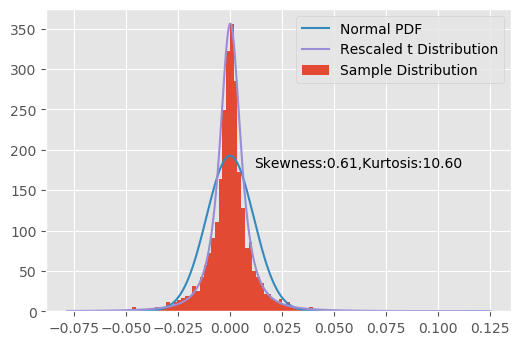

In [6]:
myhist(df.diff().dropna(),bins=100)

In [7]:
def myvar(df_input, alphas=[0.01, 0.05], method="all", tell=True):
    if method not in ["all", "norm", "t", "historical"]:
        print("Fail: wrong method! Please use one of the following method:")
        for i in ["all", "norm", "t", "historical"]:
            print(i)
        return "Error"
    import matplotlib.pyplot as plt
    import matplotlib.style as style
    import scipy.stats as stats
    import numpy as np

    alphas = np.array(alphas)

    try:
        palphas = [item * 100 for item in alphas]
    except:
        palphas = 100 * alphas

    df_input = np.array(df_input)
    if df_input.ndim > 1:
        if df_input.shape[0] > 1:
            df_input = df_input[:, 0]
        else:
            df_input = df_input[0, :]

    # parametric method with norm distribution
    # Analytic Approach
    if method == "norm" or method == "all":
        nloc, nscale = stats.norm.fit(df_input)
        vars = stats.norm.ppf(alphas, loc=nloc, scale=nscale)
        if tell == True or method == "all":
            print("Use Norm-Distribution model:")
            try:
                for var, alpha in zip(vars, alphas):
                    print("Var {}: \t{} ".format(alpha, var))
            except:
                for var, alpha in zip([vars], [alphas]):
                    print("Var {}: \t{} ".format(alpha, var))               

        if method != "all":
            return vars

    # parametric method with t location-scale distribution
    # fit the data with a t location-scale model with MLE
    ## r=loc + scale * T(dof)

    if method == "t" or method == "all":
        tdof, tloc, tscale = stats.t.fit(df_input)
        vars = stats.t.ppf(alphas, df=tdof, loc=tloc, scale=tscale)
        if tell == True or method == "all":
            print("Use t location-scale model:")
            try:
                for var, alpha in zip(vars, alphas):
                    print("Var {}: \t{} ".format(alpha, var))
            except:
                for var, alpha in zip([vars], [alphas]):
                    print("Var {}: \t{} ".format(alpha, var))               

        if method != "all":
            return vars

    # historical method
    if method == "historical" or method == "all":
        vars = np.percentile(df_input, palphas)
        if tell == True or method == "all":
            print("Use Historical Approach:")
            try:
                for var, alpha in zip(vars, alphas):
                    print("Var {}: \t{} ".format(alpha, var))
            except:
                for var, alpha in zip([vars], [alphas]):
                    print("Var {}: \t{} ".format(alpha, var))               

        if method != "all":
            return vars

In [8]:
myvar(-df.diff().dropna())

Use Norm-Distribution model:
Var 0.01: 	-0.026285248446560674 
Var 0.05: 	-0.01855168169434539 
Use t location-scale model:
Var 0.01: 	-0.03850242016813349 
Var 0.05: 	-0.015976517300130492 
Use Historical Approach:
Var 0.01: 	-0.03202699999999983 
Var 0.05: 	-0.016899999999999693 


In [9]:
myvar(-df.diff().dropna(),alphas=0.05)

Use Norm-Distribution model:
Var 0.05: 	-0.01855168169434539 
Use t location-scale model:
Var 0.05: 	-0.015976517300130492 
Use Historical Approach:
Var 0.05: 	-0.016899999999999693 


In [10]:
import pandas as pd
import scipy.stats as stats
df.index=pd.to_datetime(df.index)

In [11]:
stats.t.fit(-df[df.index.year==2015].diff().dropna())

(2.1191506485298905, -0.0003573479774021211, 0.0033118665314046643)

In [12]:
# split the data according to years
for i in range(2015,2021):
    print("For year {}:".format(i))
    [var1,var2]=myvar(-df[df.index.year==i].diff().dropna(),method="t",tell=False)
    print("Var_001={:.5f}, Var_005={:.5f}".format(var1,var2))
    parameters=stats.t.fit(-df[df.index.year==i].diff().dropna())
    print("DF={}\t Loc={}\t Scale={}".format(*parameters))
    print("The stats are:")
    statistics=stats.t.stats(*parameters,moments="mvsk")
    print("Mean={}\t Variance={}\t Skew={}\t Kurtosis={}".format(*statistics))
    print("-------------------------------------------")
    

For year 2015:
Var_001=-0.02174, Var_005=-0.00967
DF=2.1191506485298905	 Loc=-0.0003573479774021211	 Scale=0.0033118665314046643
The stats are:
Mean=-0.0003573479774021211	 Variance=0.00019507924835933103	 Skew=nan	 Kurtosis=inf
-------------------------------------------
For year 2016:
Var_001=-0.03791, Var_005=-0.02672
DF=30.38360428533606	 Loc=-0.0016970329111889392	 Scale=0.01474679018263223
The stats are:
Mean=-0.0016970329111889392	 Variance=0.00023279130240941903	 Skew=0.0	 Kurtosis=0.2274139626682767
-------------------------------------------
For year 2017:
Var_001=-0.03598, Var_005=-0.02015
DF=3.909204945009426	 Loc=0.0004389008501843616	 Scale=0.009594564218537008
The stats are:
Mean=0.0004389008501843616	 Variance=0.0001884891677933001	 Skew=0.0	 Kurtosis=inf
-------------------------------------------
For year 2018:
Var_001=-0.04581, Var_005=-0.02961
DF=6.928003990648509	 Loc=-0.0018873282916623169	 Scale=0.014608518339444824
The stats are:
Mean=-0.0018873282916623169	 Var

In [13]:
def myes(df_input, alphas=[0.01, 0.05], num_of_simus=1000000, method="all", tell=True):
    if method not in ["all", "norm", "t", "historical"]:
        print("Fail: wrong method! Please use one of the following method:")
        for i in ["all", "norm", "t", "historical"]:
            print(i)
        return "Error"

    import matplotlib.pyplot as plt
    import matplotlib.style as style
    import scipy.stats as stats
    import numpy as np

    alphas = np.array(alphas)

    try:
        palphas = [item * 100 for item in alphas]
    except:
        palphas = 100 * alphas

    df_input = np.array(df_input)
    if df_input.ndim > 1:
        if df_input.shape[0] > 1:
            df_input = df_input[:, 0]
        else:
            df_input = df_input[0, :]

    # parametric method with norm distribution
    if method == "norm" or method == "all":
        nloc, nscale = stats.norm.fit(df_input)
        vars = stats.norm.ppf(alphas, loc=nloc, scale=nscale)
        nrvs = stats.norm.rvs(loc=nloc, scale=nscale, size=num_of_simus)
        try:
            ess = [nrvs[nrvs < var].mean() for var in vars]
        except:
            ess= nrvs[nrvs < vars].mean()
        if tell == True or method == "all":
            print("Use Analytical Norm-Distribution model:")
            try:
                for es, alpha in zip(ess, alphas):
                    print("ES {}: \t{} ".format(alpha, es))
            except:
                for es, alpha in zip([ess], [alphas]):
                    print("ES {}: \t{} ".format(alpha, es))
        if method != "all":
            return ess

    # parametric method with t location-scale distribution
    # fit the data with a t location-scale model with MLE
    ## r=loc + scale * T(dof)

    if method == "t" or method == "all":
        tdof, tloc, tscale = stats.t.fit(df_input)
        vars = stats.t.ppf(alphas, df=tdof, loc=tloc, scale=tscale)
        trvs = stats.t.rvs(df=tdof, scale=tscale, size=num_of_simus, loc=tloc)
        try:
            ess = [nrvs[nrvs < var].mean() for var in vars]
        except:
            ess= nrvs[nrvs < vars].mean()

        if tell == True or method == "all":
            print("Use Analytical t location-scale model:")
            try:
                for es, alpha in zip(ess, alphas):
                    print("ES {}: \t{} ".format(alpha, es))
            except:
                for es, alpha in zip([ess], [alphas]):
                    print("ES {}: \t{} ".format(alpha, es))
        if method != "all":
            return ess

    # historical method
    if method == "historical" or method == "all":
        vars = np.percentile(df_input, palphas)
        try:
            ess = [nrvs[nrvs < var].mean() for var in vars]
        except:
            ess= nrvs[nrvs < vars].mean()
        if tell == True or method == "all":
            print("Use Historical Approach:")
            try:
                for es, alpha in zip(ess, alphas):
                    print("ES {}: \t{} ".format(alpha, es))
            except:
                for es, alpha in zip([ess], [alphas]):
                    print("ES {}: \t{} ".format(alpha, es))
        if method != "all":
            return ess


In [14]:
# the logreturn of USD/RMB
import numpy as np
usdr=np.log(df).diff().dropna()
var001=[]
var005=[]
for i in range(2010,2021):
    # print("For year {}:".format(i))
    # myvar(usdr[usdr.index.year==i],alphas=[0.01,0.05,0.1],method='t',tell=True)
    # myes(usdr[usdr.index.year==i],alphas=[0.01,0.05,0.1],method='t',tell=True)
    var001.append(myvar(usdr[usdr.index.year==i],alphas=0.01,method='t',tell=False))
    var005.append(myvar(usdr[usdr.index.year==i],alphas=0.05,method='t',tell=False))

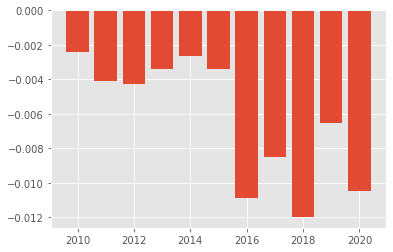

In [16]:
import matplotlib.pyplot as plt
plt.bar(range(2010,2021),var001)
# plt.bar(range(2010,2021),var005)
plt.show()

# import seaborn as sns
# sns.barplot(x=np.arange(2010,2021),y=var001)

In [17]:
# Instead of using yearly data, we use rolling of last 50 days' data to predict the VAR
var_rolling_t=usdr.rolling(window=250,min_periods=250).apply(lambda t: myvar(t,alphas=0.05,method='t',tell=False))
var_rolling_n=usdr.rolling(window=250,min_periods=250).apply(lambda t: myvar(t,alphas=0.05,method='norm',tell=False))
std_rolling_n=usdr.rolling(window=250,min_periods=250).std()

In [18]:
mvar_rollint_t=var_rolling_t.rolling(window=60,min_periods=60).mean()
mvar_rollint_n=var_rolling_n.rolling(window=60,min_periods=60).mean()

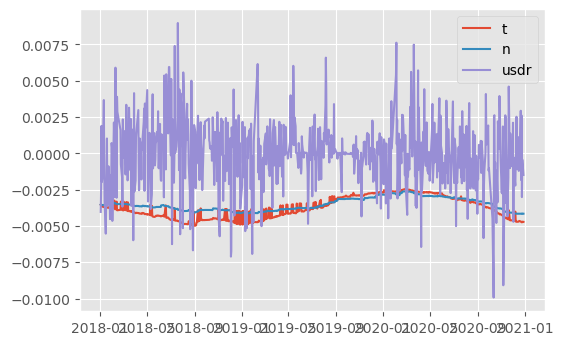

In [21]:

import matplotlib.pyplot as plt
import matplotlib.style as style
import scipy.stats as stats
import numpy as np



style.use("ggplot")
plt.rcParams["figure.figsize"] = (6, 4)
plt.figure(dpi=100)

plt.plot(var_rolling_t[var_rolling_t.index.year>2017])
plt.plot(var_rolling_n[var_rolling_n.index.year>2017])
# plt.plot(mvar_rollint_t[mvar_rollint_t.index.year>2017])
# plt.plot(mvar_rollint_n[mvar_rollint_n.index.year>2017])
plt.plot(usdr[usdr.index.year>2017])
# plt.plot(std_rolling_n)
plt.legend(['t','n','usdr'])


In [22]:
# Back-testing for different year with window size=250
for nyear in usdr.index.year.drop_duplicates('first').to_list()[1:]:

    ## t-model  
    print("for year {}:".format(nyear))
    realprob_t=(usdr<var_rolling_t.shift(1)).loc[var_rolling_t.shift(1).dropna().index,'CLOSE']
    tmean=realprob_t[realprob_t.index.year==nyear].mean()

    # print("For t model:\nP(loss < Var_005) = {:.4f}".format(tmean))
    bn=realprob_t[realprob_t.index.year==nyear].count()
    bx=realprob_t[realprob_t.index.year==nyear].sum()
    # print("bx={},bn={}".format(bx,bn))
    bp=stats.binom_test(bx,bn,p=0.05)
    print("p-value for t model = {:.4f}".format(bp))
    ## norm-model
    realprob_n=(usdr<var_rolling_n.shift(1)).loc[var_rolling_n.shift(1).dropna().index,'CLOSE']
    nmean=realprob_n[realprob_n.index.year==nyear].mean()
    # print("For norm model:\nP(loss < Var_005) = {:.4f}".format(nmean))
    bn=realprob_n[realprob_n.index.year==nyear].count()
    bx=realprob_n[realprob_n.index.year==nyear].sum()
    # print("bx={},bn={}".format(bx,bn))
    bp=stats.binom_test(bx,bn,p=0.05)
    print("p-value for norm model= {:.4f}".format(bp))

    

for year 2011:
p-value for t model = 0.1781
p-value for norm model= 1.0000
for year 2012:
p-value for t model = 0.0030
p-value for norm model= 0.1417
for year 2013:
p-value for t model = 0.0990
p-value for norm model= 0.2311
for year 2014:
p-value for t model = 0.4612
p-value for norm model= 0.6588
for year 2015:
p-value for t model = 0.3778
p-value for norm model= 0.0761
for year 2016:
p-value for t model = 0.0000
p-value for norm model= 0.2408
for year 2017:
p-value for t model = 0.8829
p-value for norm model= 1.0000
for year 2018:
p-value for t model = 0.5548
p-value for norm model= 0.0538
for year 2019:
p-value for t model = 0.4605
p-value for norm model= 0.4605
for year 2020:
p-value for t model = 0.0517
p-value for norm model= 0.0517


In [23]:
# Back-testing for different year with window size=250
for nyear in usdr.index.year.drop_duplicates('first').to_list()[1:]:
    mvar_rolling_t=mvar_rollint_t
    mvar_rolling_n=mvar_rollint_n
    ## t-model  
    print("for year {}:".format(nyear))
    realprob_t=(usdr<mvar_rolling_t.shift(1)).loc[mvar_rolling_t.shift(1).dropna().index,'CLOSE']
    tmean=realprob_t[realprob_t.index.year==nyear].mean()

    # print("For t model:\nP(loss < Var_005) = {:.4f}".format(tmean))
    bn=realprob_t[realprob_t.index.year==nyear].count()
    bx=realprob_t[realprob_t.index.year==nyear].sum()
    # print("bx={},bn={}".format(bx,bn))
    bp=stats.binom_test(bx,bn,p=0.05)
    print("p-value for t model = {:.4f}".format(bp))
    ## norm-model
    realprob_n=(usdr<mvar_rolling_n.shift(1)).loc[mvar_rolling_n.shift(1).dropna().index,'CLOSE']
    nmean=realprob_n[realprob_n.index.year==nyear].mean()
    # print("For norm model:\nP(loss < Var_005) = {:.4f}".format(nmean))
    bn=realprob_n[realprob_n.index.year==nyear].count()
    bx=realprob_n[realprob_n.index.year==nyear].sum()
    # print("bx={},bn={}".format(bx,bn))
    bp=stats.binom_test(bx,bn,p=0.05)
    print("p-value for norm model= {:.4f}".format(bp))

    

for year 2011:
p-value for t model = 0.7277
p-value for norm model= 0.8627
for year 2012:
p-value for t model = 0.0115
p-value for norm model= 0.3000
for year 2013:
p-value for t model = 0.0990
p-value for norm model= 0.5495
for year 2014:
p-value for t model = 0.4612
p-value for norm model= 0.8830
for year 2015:
p-value for t model = 0.3778
p-value for norm model= 0.6584
for year 2016:
p-value for t model = 0.0000
p-value for norm model= 0.2408
for year 2017:
p-value for t model = 0.4605
p-value for norm model= 0.7683
for year 2018:
p-value for t model = 0.5548
p-value for norm model= 0.0538
for year 2019:
p-value for t model = 0.4605
p-value for norm model= 0.4605
for year 2020:
p-value for t model = 0.0251
p-value for norm model= 0.0163


In [47]:
# Back-testing for all year with window size=250
## t-model  
realprob_t=(usdr<var_rolling_t.shift(1)).loc[var_rolling_t.shift(1).dropna().index,'CLOSE']
tmean=realprob_t.mean()

# print("For t model:\nP(loss < Var_005) = {:.4f}".format(tmean))
bn=realprob_t.count()
bx=realprob_t.sum()
# print("bx={},bn={}".format(bx,bn))
bp=stats.binom_test(bx,bn,p=0.05)
print("p-value for t model = {:.4f}".format(bp))
## norm-model
realprob_n=(usdr<var_rolling_n.shift(1)).loc[var_rolling_n.shift(1).dropna().index,'CLOSE']
nmean=realprob_n[realprob_n.index.year==nyear].mean()
# print("For norm model:\nP(loss < Var_005) = {:.4f}".format(nmean))
bn=realprob_n.count()
bx=realprob_n.sum()
# print("bx={},bn={}".format(bx,bn))
bp=stats.binom_test(bx,bn,p=0.05)
print("p-value for norm model= {:.4f}".format(bp))


p-value for t model = 1.0000
p-value for norm model= 0.7089


In [48]:
# Back-testing for different window size
## t-model
realprob_t=(usdr<var_rolling_t.shift(1)).loc[var_rolling_t.shift(1).dropna().index,'CLOSE'].mean()
print("For t model, the probability of loss < Var_005 is {:.4f}".format(realprob_t))
## norm-model
realprob_n=(usdr<var_rolling_n.shift(1)).loc[var_rolling_n.shift(1).dropna().index,'CLOSE'].mean()
print("For norm model, the probability of loss < Var_005 is {:.4f}".format(realprob_n))

For t model, the probability of loss < Var_005 is 0.0500
For norm model, the probability of loss < Var_005 is 0.0517


In [49]:
# Find which is the optimal number of observations to fit the t model and norm model
bt_prob_t=[]
bt_prob_n=[]
for i in range(1,15):
    var_rolling_t=usdr.rolling(window=i*50,min_periods=i*50).apply(lambda t: myvar(t,alphas=[0.05],method='t',tell=False)[0])
    var_rolling_n=usdr.rolling(window=i*50,min_periods=i*50).apply(lambda t: myvar(t,alphas=[0.05],method='norm',tell=False)[0])
    pt=(usdr<var_rolling_t.shift(1)).loc[var_rolling_t.shift(1).dropna().index].mean()
    pn=(usdr<var_rolling_n.shift(1)).loc[var_rolling_n.shift(1).dropna().index].mean()
    bt_prob_t.append(pt)
    bt_prob_n.append(pn)
    # print("finish with {}".format(i*50))


    

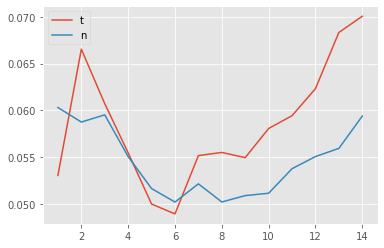

In [50]:
%matplotlib inline
plt.plot(range(1,15),bt_prob_t)
plt.plot(range(1,15),bt_prob_n)
plt.legend(['t','n'])

In [51]:
XX=(usdr<var_rolling_t.shift(1)).loc[var_rolling_t.shift(1).dropna().index,'CLOSE']
XX=XX.astype('int')
XX.mean()

In [16]:
usdr['lag1']=usdr.shift(1)

In [18]:
usdr['lag2']=usdr['lag1'].shift(1)

In [20]:
usdrlags=usdr.dropna()
usdrlags.corr()

,CLOSE,lag1,lag2
CLOSE,1.000000,0.122163,0.044473
lag1,0.122163,1.000000,0.122103
lag2,0.044473,0.122103,1.000000


In [21]:
import scipy.stats as stats

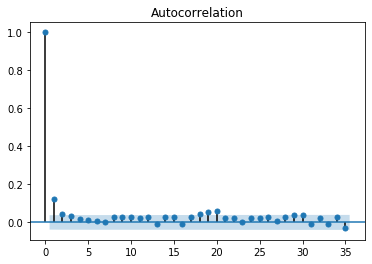

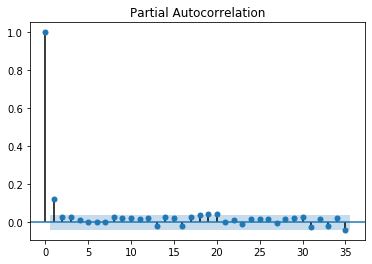

In [34]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
acfs=plot_acf(usdr['CLOSE'])
pacfs=plot_pacf(usdr['CLOSE'])